# Homework 2 (Loans)

Description from Kaggle competation:  
The goal is to decide whether or not to approve a loan to a new client based on the predictors that are provided. If you predict a 1, that means that you are predicting that the customer will pay back the laon. The data columns are described in the MetaData.csv file. The response for training is the MIS_Status column, where PIF = paid in full = a successful loan.

You'll evaluate using the mean F1 score (see the Kaggle overview page for more information). Mean F1 scores closer to 1 are better scores. On the leaderboard I've included a benchmark which I created by randomly predicting 0 or 1 for the test data set (see random.guess on the leaderboard).

In [5]:
# import analysis packages
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import models
from keras.regularizers import l2
from keras.utils import to_categorical
import keras.backend as back
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

### Data Cleaning

In [89]:
# read data from .csvs
trainDF = pd.read_csv('./loan_train.csv')
testDF = pd.read_csv('./loan_test.csv')

# separate response/prediction columns
trainResp = np.where(trainDF['MIS_Status'] == 'P I F', 1, 0)
trainDF.drop('MIS_Status', axis = 1, inplace = True)
testIDs = testDF['CustomerId']
testDF.drop('CustomerId', axis = 1, inplace = True)

# combine data sets for preprocessing``
trainDF['source'] = 'train'
testDF['source'] = 'test'
fullDF = pd.concat([trainDF, testDF], axis = 0)

# check data frame dimensions
display(trainDF.shape)
display(testDF.shape)
display(fullDF.shape)

# factor categorical predictors
fullDF['NAICS'] = fullDF['NAICS'].apply(lambda x: str(x))
fullDF['NewExist'] = fullDF['NewExist'].apply(lambda x: str(x))
fullDF['UrbanRural'] = fullDF['UrbanRural'].apply(lambda x: str(x))
fullDF['RevLineCr'] = np.where(fullDF['RevLineCr'] == 'Y', 'Y', 'N')
fullDF['LowDoc'] = np.where(fullDF['LowDoc'] == 'Y', 'Y', 'N')
fullDF['New'] = fullDF['New'].apply(lambda x: str(x))
fullDF['RealEstate'] = fullDF['RealEstate'].apply(lambda x: str(x))
fullDF['Recession'] = fullDF['Recession'].apply(lambda x: str(x))

# selected predictors
predictors = ['NAICS', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'GrAppv', 'New', 'RealEstate', 'Portion', 'Recession']
src = fullDF['source']
fullDF = fullDF[predictors]

# check data types
display(fullDF.info())

# peek at data
display(fullDF.head())

(1102, 31)

(1000, 31)

(2102, 31)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NAICS              2102 non-null   object 
 1   Term               2102 non-null   int64  
 2   NoEmp              2102 non-null   int64  
 3   CreateJob          2102 non-null   int64  
 4   RetainedJob        2102 non-null   int64  
 5   UrbanRural         2102 non-null   object 
 6   RevLineCr          2102 non-null   object 
 7   LowDoc             2102 non-null   object 
 8   DisbursementGross  2102 non-null   int64  
 9   GrAppv             2102 non-null   int64  
 10  New                2102 non-null   object 
 11  RealEstate         2102 non-null   object 
 12  Portion            2102 non-null   float64
 13  Recession          2102 non-null   object 
dtypes: float64(1), int64(6), object(7)
memory usage: 246.3+ KB


None

,NAICS,Term,NoEmp,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,GrAppv,New,RealEstate,Portion,Recession
0,531210,84,2,0,0,2,Y,N,11000,11000,0,0,0.50000,0
1,531312,300,7,0,7,1,N,N,866800,866800,0,1,0.75000,0
2,532230,84,3,0,3,1,Y,N,77377,85000,0,0,0.50000,0
3,531312,300,10,0,0,1,N,N,800100,810000,0,1,0.75000,0
4,531210,300,2,0,2,1,N,N,1054200,1056200,0,1,0.72611,0


In [90]:
# scale numeric predictors and encode categorical predictors
findNumPredictors = make_column_selector(dtype_exclude = object)
findCatPredictors = make_column_selector(dtype_include = object)
transform = make_column_transformer((MinMaxScaler(), findNumPredictors),
                                    (OneHotEncoder(), findCatPredictors))

# get new column names
colNames = transform.fit(fullDF).get_feature_names_out()

# transform data
modelDF = pd.DataFrame(transform.fit_transform(fullDF), columns = colNames)

In [91]:
# split data into training, validation, and test sets
modelTrain = modelDF.loc[np.where(src == 'train')]
modelTest = modelDF.iloc[np.where(src == 'test')]
X_train, X_valid, y_train, y_valid = train_test_split(modelTrain, trainResp, test_size = 0.2, random_state = 4192023)

# check data frame dimensions
display(X_train.shape)
display(y_train.shape)
display(X_valid.shape)
display(y_valid.shape)
display(modelTest.shape) 

(881, 44)

(881,)

(221, 44)

(221,)

(1000, 44)

### Modeling

In [92]:
# set random seed
np.random.seed(4192023)

# tune KNN model
Kvalues = range(1, 50)
knnFit = KNeighborsClassifier()
knnTune = GridSearchCV(knnFit, param_grid = {'n_neighbors': Kvalues}, cv = 5, n_jobs = -1, verbose = 1)
knnTune.fit(X_train, y_train)
K = knnTune.best_params_['n_neighbors']

# fit KNN model
knnFit = KNeighborsClassifier(n_neighbors = K)
cvResults = cross_val_score(knnFit, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
display(f"Neighbors considered: {K}")
display(f"Cross-validation F1 score: {(np.mean(cvResults)).round(3)}")

Fitting 5 folds for each of 49 candidates, totalling 245 fits


'Neighbors considered: 11'

'Cross-validation F1 score: 0.808'

In [93]:
# tune random forest classifier
Mvalues = range(1, len(X_train.columns))
rfFit = RandomForestClassifier(random_state = 4192023)
rfTune = GridSearchCV(rfFit, param_grid = {'max_features': Mvalues}, cv = 5, n_jobs = -1, verbose = 1)
rfTune.fit(X_train, y_train)
M = rfTune.best_params_['max_features']

# fit random forest model
rfFit = RandomForestClassifier(max_features = M, n_estimators = 1000, random_state = 4192023)
cvResults = cross_val_score(rfFit, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
display(f"Features considered: {M}")
display(f"Cross-validation F1 score: {(np.mean(cvResults)).round(3)}")

Fitting 5 folds for each of 43 candidates, totalling 215 fits


'Features considered: 38'

'Cross-validation F1 score: 0.842'

In [94]:
# fit random forest model on full training set
rfFitted = rfFit.fit(X_train, y_train)

# identify most important predictors
pd.DataFrame({'Feature': rfFitted.feature_names_in_,
              'Importance': rfFitted.feature_importances_}).sort_values('Importance', ascending = False).head(10)

,Feature,Importance
0,minmaxscaler__Term,0.467132
4,minmaxscaler__DisbursementGross,0.110128
5,minmaxscaler__GrAppv,0.088020
1,minmaxscaler__NoEmp,0.059972
3,minmaxscaler__RetainedJob,0.047735
2,minmaxscaler__CreateJob,0.038779
6,minmaxscaler__Portion,0.021180
11,onehotencoder__NAICS_531210,0.014590
29,onehotencoder__NAICS_532490,0.011558
12,onehotencoder__NAICS_531311,0.009137


In [95]:
# tune gradient boosted classifier
Lvalues = [.001, .01, .1, 1, 10, 100]
Dvalues = range(1, 8)
gbFit = GradientBoostingClassifier(n_estimators = 1000, random_state = 4192023)
gbTune = GridSearchCV(gbFit, param_grid = {'learning_rate': Lvalues, 'max_depth': Dvalues}, cv = 5, n_jobs = -1, verbose = 1)
gbTune.fit(X_train, y_train)
L = gbTune.best_params_['learning_rate']
D = gbTune.best_params_['max_depth']

# fit gradient boosted model
gbFit = GradientBoostingClassifier(learning_rate = L, max_depth = D, n_estimators = 1000, random_state = 4192023)
cvResults = cross_val_score(gbFit, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
display(f"Learning rate: {L}")
display(f"Maximum depth: {D}")
display(f"Cross-validation F1 score: {(np.mean(cvResults)).round(3)}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits


'Learning rate: 0.1'

'Maximum depth: 1'

'Cross-validation F1 score: 0.855'

In [96]:
# fit gradient boosted model on full training set
gbFitted = gbFit.fit(X_train, y_train)

# identify most important predictors
pd.DataFrame({'Feature': gbFitted.feature_names_in_,
              'Importance': gbFitted.feature_importances_}).sort_values('Importance', ascending = False).head(10)

,Feature,Importance
0,minmaxscaler__Term,0.864660
5,minmaxscaler__GrAppv,0.020106
3,minmaxscaler__RetainedJob,0.019010
4,minmaxscaler__DisbursementGross,0.018880
1,minmaxscaler__NoEmp,0.015883
6,minmaxscaler__Portion,0.011253
2,minmaxscaler__CreateJob,0.011012
29,onehotencoder__NAICS_532490,0.009241
15,onehotencoder__NAICS_531390,0.007810
7,onehotencoder__NAICS_531110,0.004013


In [156]:
# model fitting and evaluation function
def EvaluateModel(model):
    # set random seed
    np.random.seed(462023)
    tf.random.set_seed(482023)

    # define F1 metric
    f1_score_metric = F1Score(num_classes = 1, threshold = 0.5)

    # compile model
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', f1_score_metric])

    # model summary
    model.summary()

    # number of epochs
    EPOCHS = 50

    # early stopping criteria
    earlyStop = EarlyStopping(monitor = 'val_f1_score', mode = 'max', verbose = 1, patience = 3)

    # train model
    trained = model.fit(X_train, 
                        y_train, 
                        epochs = EPOCHS, 
                        batch_size = 64, 
                        validation_split = 0.2,
                        callbacks = earlyStop,
                        verbose = 1)

    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    f1_score = trained.history['f1_score']
    val_f1_score = trained.history['val_f1_score']
    epochs = range(1, len(acc) + 1)

    # plot training accuracy
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 5))
    ax1.plot(epochs, acc, 'bo', label = 'Training acc')
    ax1.plot(epochs, val_acc, 'b', label = 'Validation acc')
    ax1.set(xlabel = 'Epochs', ylabel = 'Accuracy')
    # ax1.xlabel('Epochs')
    # ax1.ylabel('Accuracy')
    # ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    # ax1.figure()
    ax2.plot(epochs, loss, 'bo', label = 'Training loss')
    ax2.plot(epochs, val_loss, 'b', label = 'Validation loss')
    # ax2.xlabel('Epochs')
    # ax2.ylabel('Loss')
    ax2.set(xlabel = 'Epochs', ylabel = 'Loss')
    # ax2.set_title('Training and Validation Loss')
    ax2.legend()
    # plt.figure()
    ax3.plot(epochs, f1_score, 'bo', label = 'Training F1')
    ax3.plot(epochs, val_f1_score, 'b', label = 'Validation F1')
    # ax3.xlabel('Epochs')
    # ax3.ylabel('F1 Score')
    ax3.set(xlabel = 'Epochs', ylabel = 'F1 Score')
    # ax3.set_title('F1 Score')
    ax3.legend()
    fig.suptitle('Evaluation Metrics')
    # fig.show()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_402 (Dense)           (None, 512)               23040     
                                                                 
 dense_403 (Dense)           (None, 256)               131328    
                                                                 
 dense_404 (Dense)           (None, 128)               32896     
                                                                 
 dense_405 (Dense)           (None, 64)                8256      
                                                                 
 dense_406 (Dense)           (None, 32)                2080      
                                                                 
 dense_407 (Dense)           (None, 1)                 33        
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-t

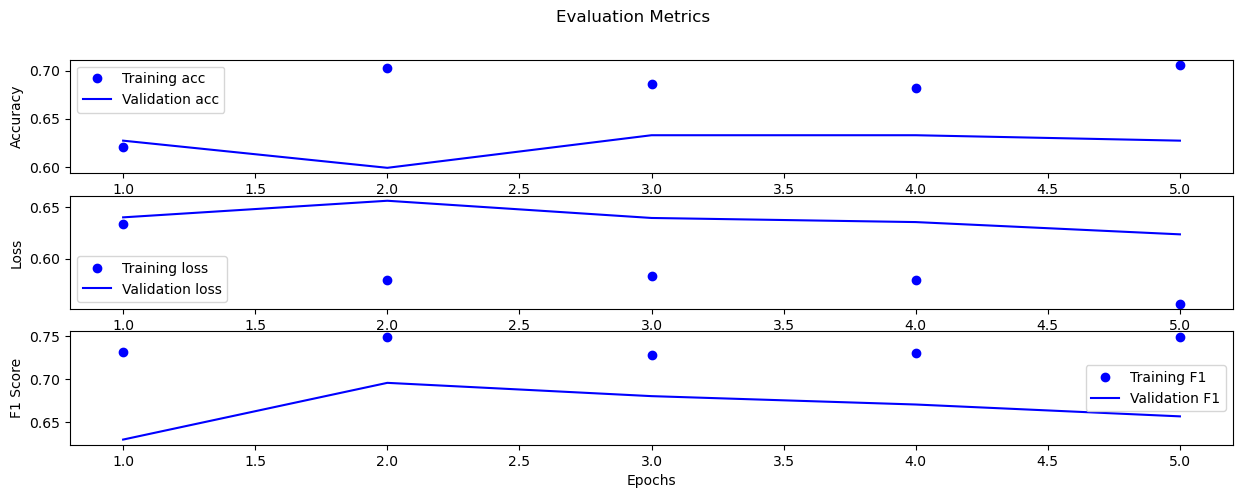

In [157]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_408 (Dense)           (None, 512)               23040     
                                                                 
 dense_409 (Dense)           (None, 256)               131328    
                                                                 
 dense_410 (Dense)           (None, 128)               32896     
                                                                 
 dense_411 (Dense)           (None, 64)                8256      
                                                                 
 dense_412 (Dense)           (None, 32)                2080      
                                                                 
 dense_413 (Dense)           (None, 1)                 33        
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-t

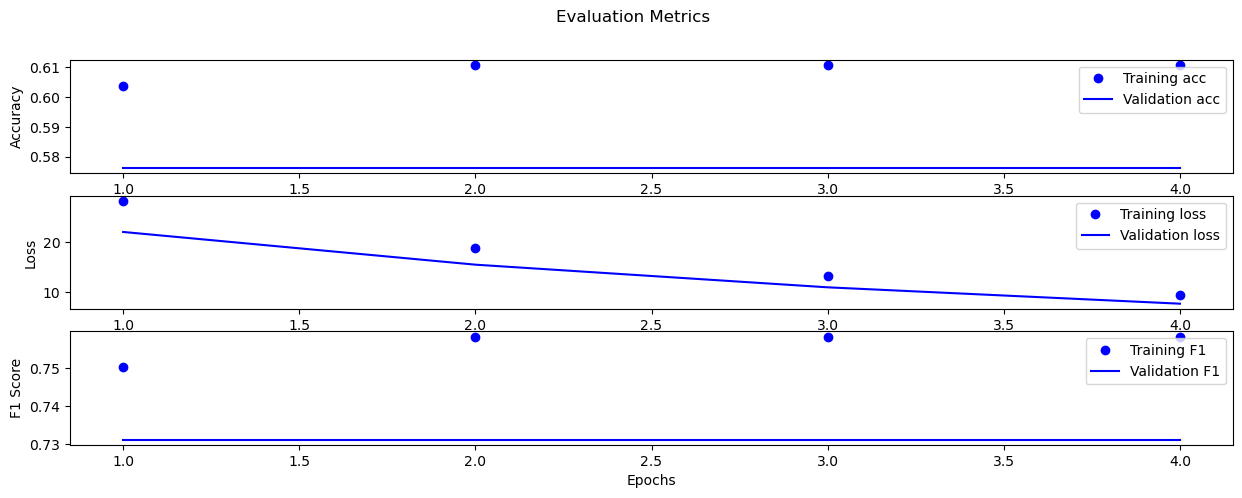

In [158]:
# penalty hyperparameter
PENALTY = 0.05

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_414 (Dense)           (None, 512)               23040     
                                                                 
 dense_415 (Dense)           (None, 256)               131328    
                                                                 
 dense_416 (Dense)           (None, 128)               32896     
                                                                 
 dense_417 (Dense)           (None, 64)                8256      
                                                                 
 dense_418 (Dense)           (None, 32)                2080      
                                                                 
 dense_419 (Dense)           (None, 1)                 33        
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-t

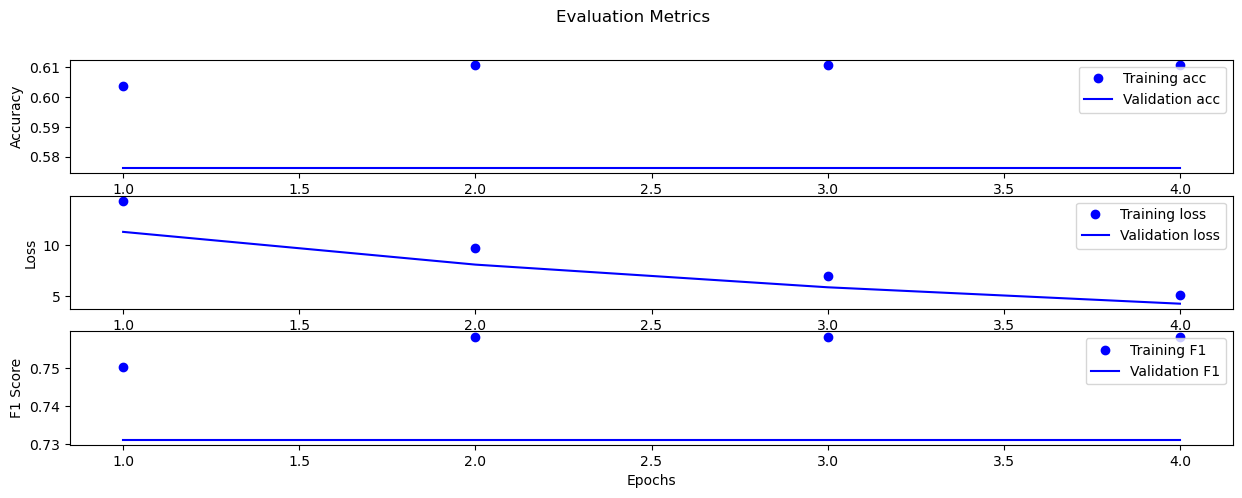

In [159]:
# penalty hyperparameter
PENALTY = 0.025

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_420 (Dense)           (None, 512)               23040     
                                                                 
 dense_421 (Dense)           (None, 256)               131328    
                                                                 
 dense_422 (Dense)           (None, 128)               32896     
                                                                 
 dense_423 (Dense)           (None, 64)                8256      
                                                                 
 dense_424 (Dense)           (None, 32)                2080      
                                                                 
 dense_425 (Dense)           (None, 1)                 33        
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-t

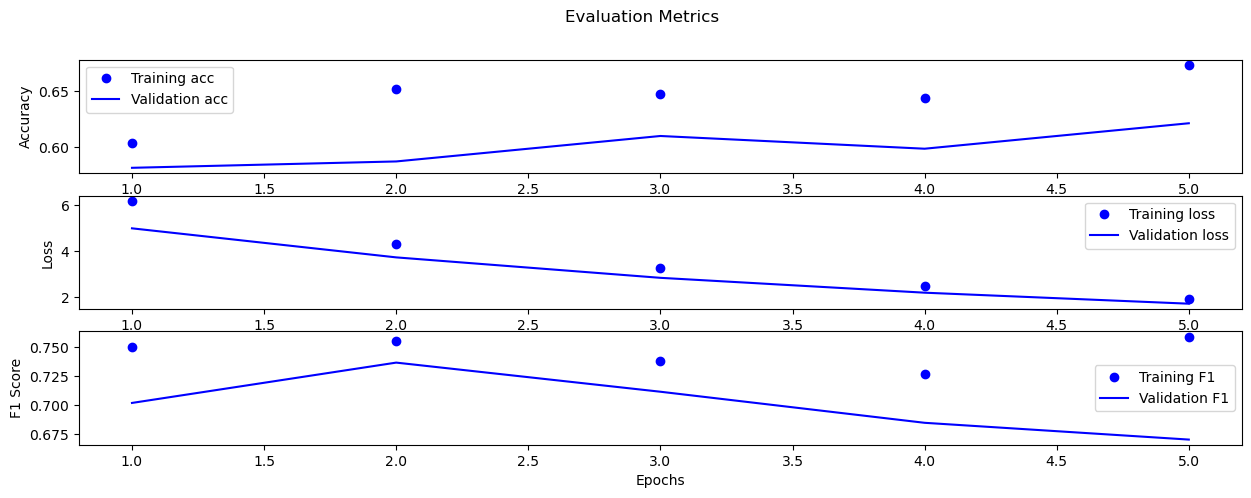

In [160]:
# penalty hyperparameter
PENALTY = 0.01

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_426 (Dense)           (None, 512)               23040     
                                                                 
 dense_427 (Dense)           (None, 256)               131328    
                                                                 
 dense_428 (Dense)           (None, 128)               32896     
                                                                 
 dense_429 (Dense)           (None, 64)                8256      
                                                                 
 dense_430 (Dense)           (None, 32)                2080      
                                                                 
 dense_431 (Dense)           (None, 1)                 33        
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-t

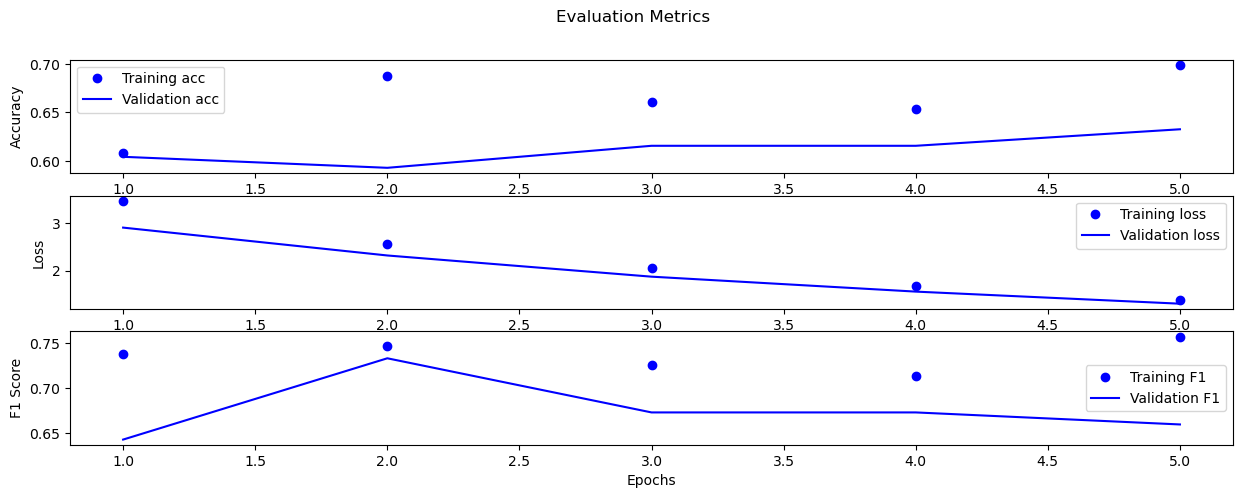

In [161]:
# penalty hyperparameter
PENALTY = 0.005

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_432 (Dense)           (None, 512)               23040     
                                                                 
 dense_433 (Dense)           (None, 256)               131328    
                                                                 
 dense_434 (Dense)           (None, 128)               32896     
                                                                 
 dense_435 (Dense)           (None, 64)                8256      
                                                                 
 dense_436 (Dense)           (None, 32)                2080      
                                                                 
 dense_437 (Dense)           (None, 1)                 33        
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-t

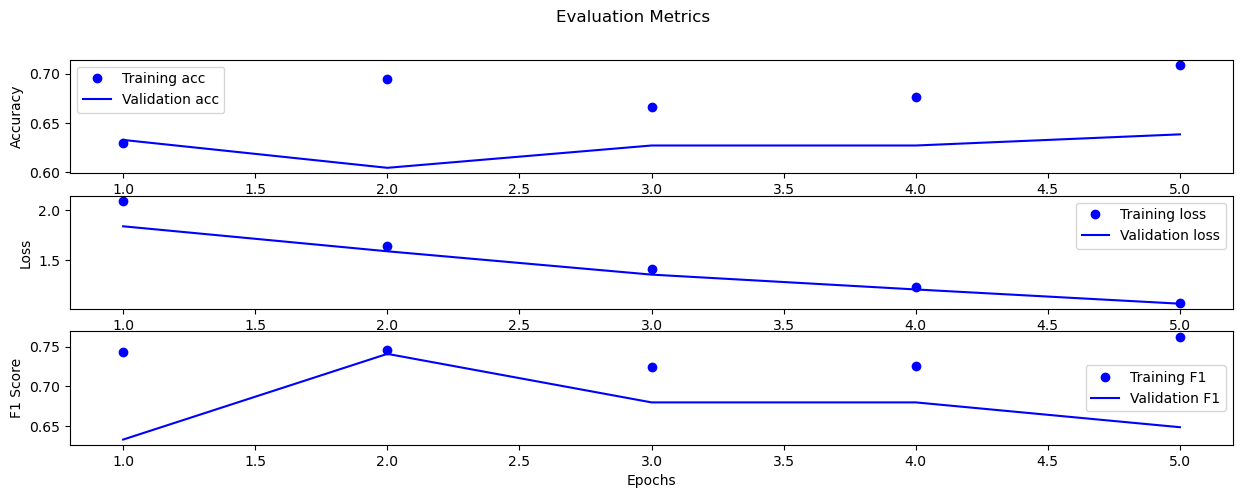

In [162]:
# penalty hyperparameter
PENALTY = 0.0025

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_438 (Dense)           (None, 512)               23040     
                                                                 
 dense_439 (Dense)           (None, 256)               131328    
                                                                 
 dense_440 (Dense)           (None, 128)               32896     
                                                                 
 dense_441 (Dense)           (None, 64)                8256      
                                                                 
 dense_442 (Dense)           (None, 32)                2080      
                                                                 
 dense_443 (Dense)           (None, 1)                 33        
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-t

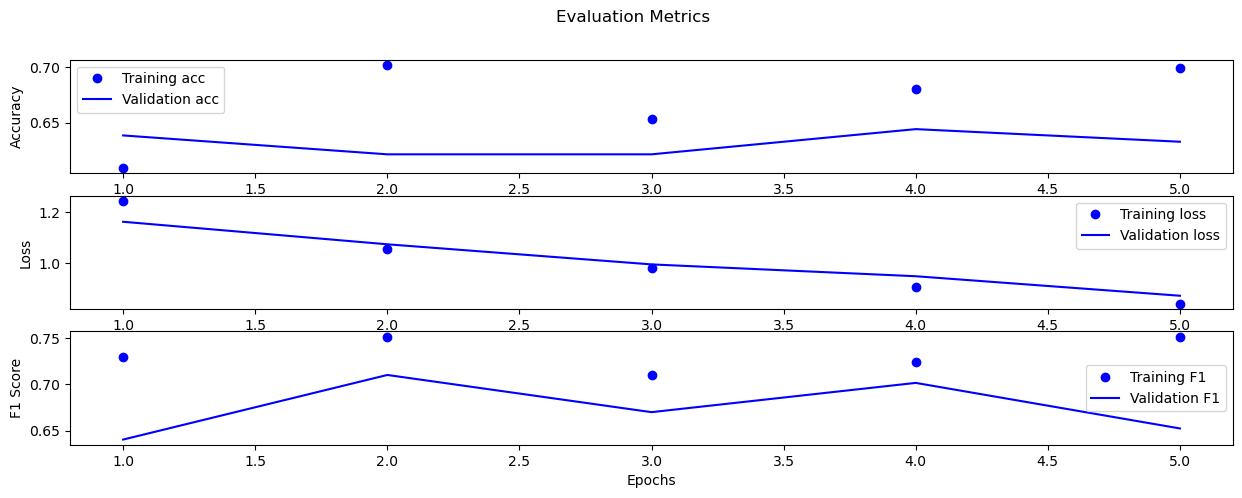

In [163]:
# penalty hyperparameter
PENALTY = 0.001

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_444 (Dense)           (None, 512)               23040     
                                                                 
 dense_445 (Dense)           (None, 256)               131328    
                                                                 
 dense_446 (Dense)           (None, 128)               32896     
                                                                 
 dense_447 (Dense)           (None, 64)                8256      
                                                                 
 dense_448 (Dense)           (None, 32)                2080      
                                                                 
 dense_449 (Dense)           (None, 1)                 33        
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-t

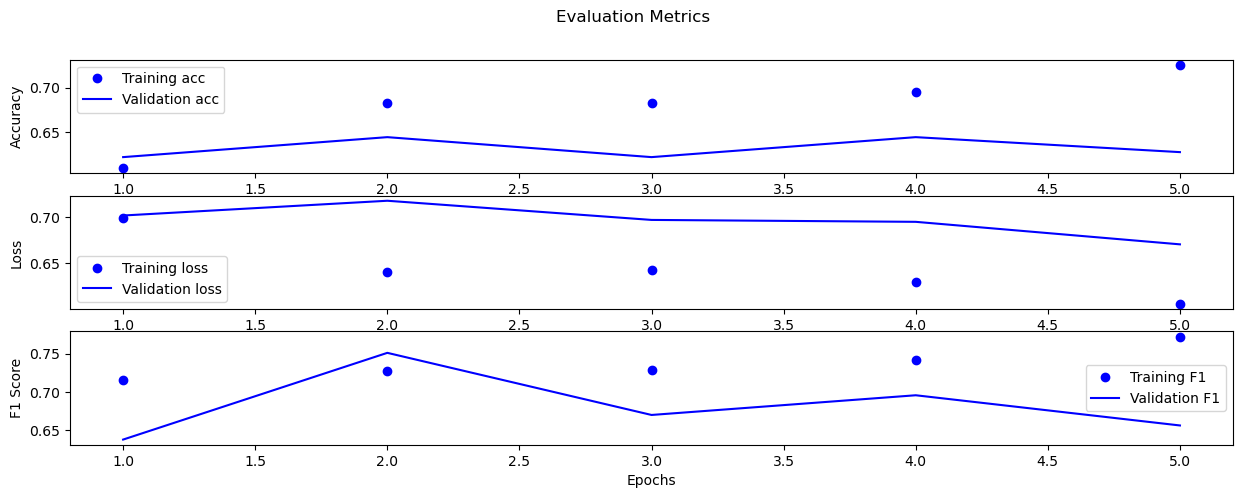

In [164]:
# penalty hyperparameter
PENALTY = 0.0001

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_450 (Dense)           (None, 512)               23040     
                                                                 
 dropout_56 (Dropout)        (None, 512)               0         
                                                                 
 dense_451 (Dense)           (None, 256)               131328    
                                                                 
 dropout_57 (Dropout)        (None, 256)               0         
                                                                 
 dense_452 (Dense)           (None, 128)               32896     
                                                                 
 dropout_58 (Dropout)        (None, 128)               0         
                                                                 
 dense_453 (Dense)           (None, 64)              

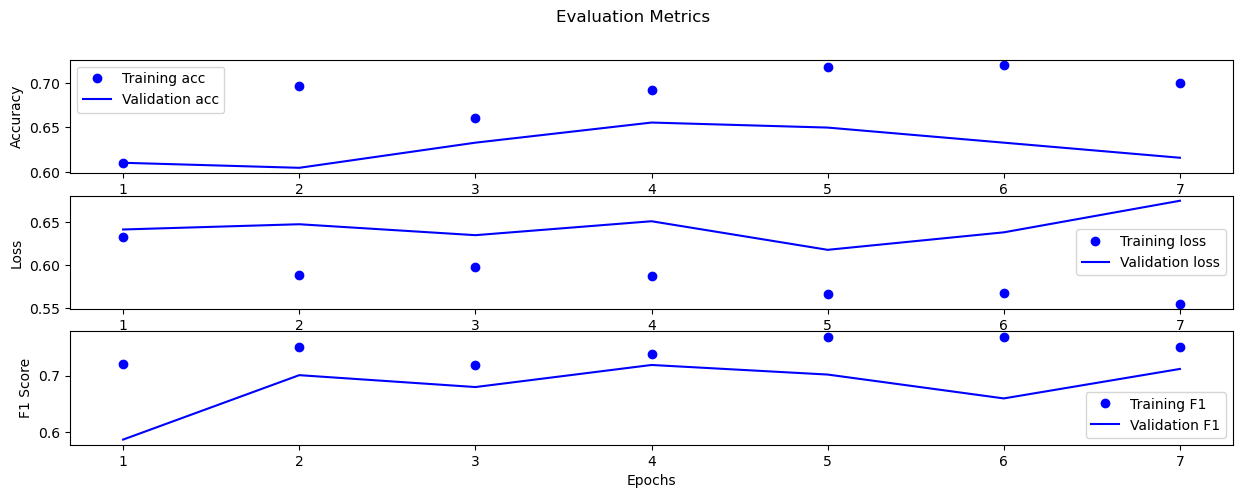

In [165]:
# penalty hyperparameter
RATE = 0.1

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(RATE),
    Dense(256, activation = 'relu'),
    Dropout(RATE),
    Dense(128, activation = 'relu'),
    Dropout(RATE),
    Dense(64, activation = 'relu'),
    Dropout(RATE),
    Dense(32, activation = 'relu'),
    Dropout(RATE),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_456 (Dense)           (None, 512)               23040     
                                                                 
 dropout_61 (Dropout)        (None, 512)               0         
                                                                 
 dense_457 (Dense)           (None, 256)               131328    
                                                                 
 dropout_62 (Dropout)        (None, 256)               0         
                                                                 
 dense_458 (Dense)           (None, 128)               32896     
                                                                 
 dropout_63 (Dropout)        (None, 128)               0         
                                                                 
 dense_459 (Dense)           (None, 64)              

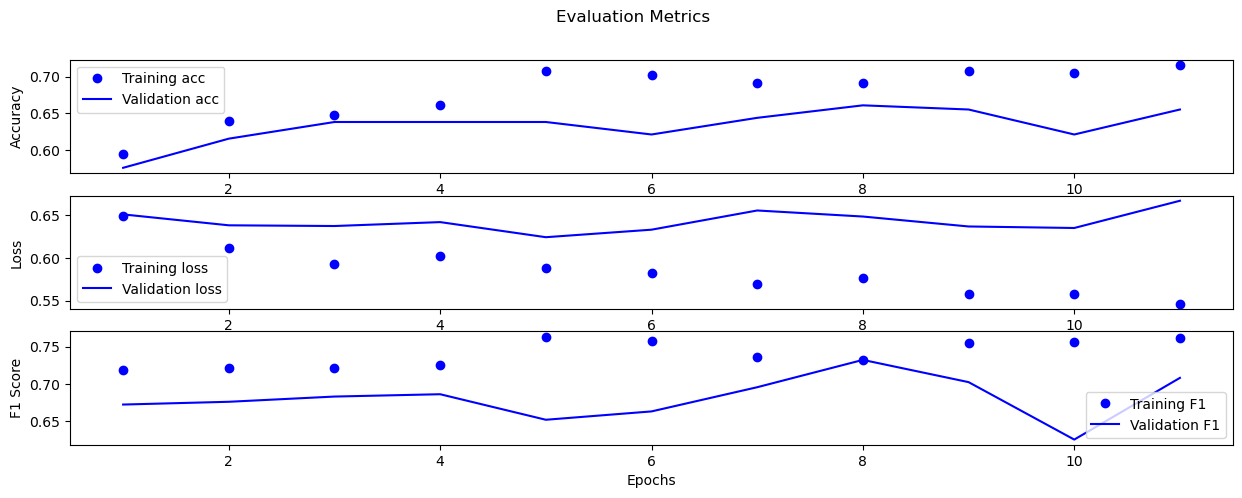

In [166]:
# penalty hyperparameter
RATE = 0.25

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(RATE),
    Dense(256, activation = 'relu'),
    Dropout(RATE),
    Dense(128, activation = 'relu'),
    Dropout(RATE),
    Dense(64, activation = 'relu'),
    Dropout(RATE),
    Dense(32, activation = 'relu'),
    Dropout(RATE),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_462 (Dense)           (None, 512)               23040     
                                                                 
 dropout_66 (Dropout)        (None, 512)               0         
                                                                 
 dense_463 (Dense)           (None, 256)               131328    
                                                                 
 dropout_67 (Dropout)        (None, 256)               0         
                                                                 
 dense_464 (Dense)           (None, 128)               32896     
                                                                 
 dropout_68 (Dropout)        (None, 128)               0         
                                                                 
 dense_465 (Dense)           (None, 64)              

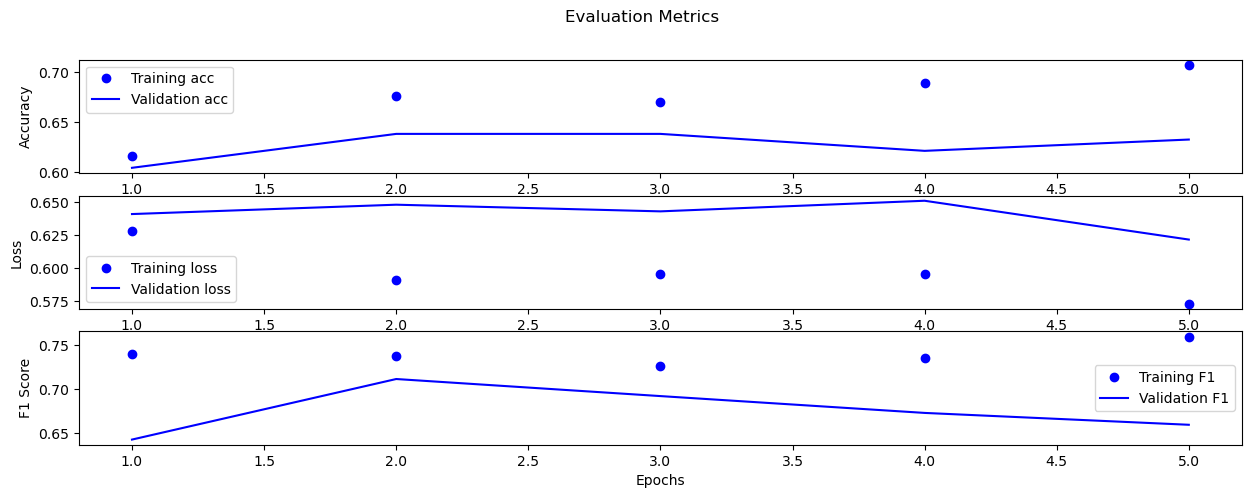

In [167]:
# penalty hyperparameter
RATE = 0.25

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(RATE),
    Dense(256, activation = 'relu'),
    Dropout(RATE),
    Dense(128, activation = 'relu'),
    Dropout(RATE),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_468 (Dense)           (None, 512)               23040     
                                                                 
 dropout_69 (Dropout)        (None, 512)               0         
                                                                 
 dense_469 (Dense)           (None, 256)               131328    
                                                                 
 dropout_70 (Dropout)        (None, 256)               0         
                                                                 
 dense_470 (Dense)           (None, 128)               32896     
                                                                 
 dropout_71 (Dropout)        (None, 128)               0         
                                                                 
 dense_471 (Dense)           (None, 64)              

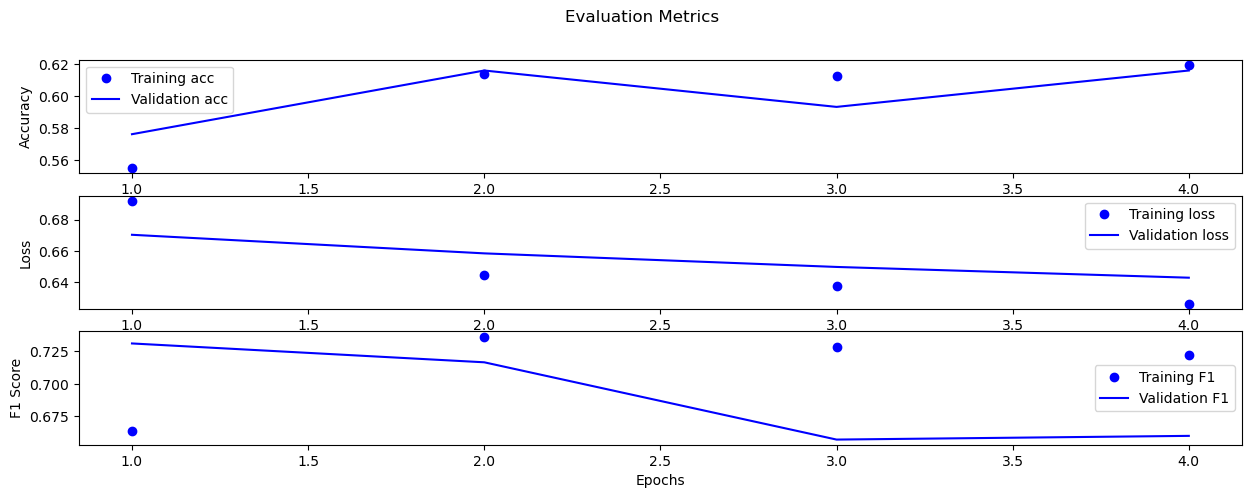

In [168]:
# penalty hyperparameter
RATE = 0.5

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(RATE),
    Dense(256, activation = 'relu'),
    Dropout(RATE),
    Dense(128, activation = 'relu'),
    Dropout(RATE),
    Dense(64, activation = 'relu'),
    Dropout(RATE),
    Dense(32, activation = 'relu'),
    Dropout(RATE),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)